In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:30<00:00, 36.5MB/s]
100% 1.03G/1.03G [00:30<00:00, 36.2MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/asl-alphabet.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def imgPaths(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [ ]:
# from pathlib import Path
# import pandas as pd

# # Assuming your function imgPaths is defined somewhere
# def imgPaths(filepaths):
#     # Your implementation here

#     # Define image directories
#     train_image_dir = Path('../input/asl-alphabet/asl_alphabet_train')
#     test_image_dir = Path('../input/asl-alphabet/asl_alphabet_test')

#     # Get file paths
#     train_filepaths = list(train_image_dir.glob(r'**/*.jpg'))
#     test_filepaths = list(test_image_dir.glob(r'**/*.jpg'))

#     # Create DataFrames
#     train_df = imgPaths(train_filepaths)
#     test_df = imgPaths(test_filepaths)

#     # If you want a DataFrame with unique labels
#     df_unique = train_df.drop_duplicates(subset=["Label"]).reset_index(drop=True)


In [ ]:
# # Assuming your function imgPaths is defined somewhere
# def imgPaths(filepaths):
#     # Your implementation here
#     # Example: Extract label from file path
#     labels = [str(filepath.parent).split("/")[-1] for filepath in filepaths]
#     df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})
#     return df

# # Define image directories
# train_image_dir = Path('../input/asl-alphabet/asl_alphabet_train')
# test_image_dir = Path('../input/asl-alphabet/asl_alphabet_test')

# # Get file paths
# train_filepaths = list(train_image_dir.glob(r'**/*.jpg'))
# test_filepaths = list(test_image_dir.glob(r'**/*.jpg'))

# # Create DataFrames
# train_df = imgPaths(train_filepaths)
# test_df = imgPaths(test_filepaths)

# # If you want a DataFrame with unique labels
# df_unique = train_df.drop_duplicates(subset=["Label"]).reset_index(drop=True)


In [ ]:

# Create Variables
train_image_dir = Path('/content/asl_alphabet_train/asl_alphabet_train')
train_filepaths = list(train_image_dir.glob(r'**/*.jpg'))

test_image_dir = Path('/content/asl_alphabet_test/asl_alphabet_test')
test_filepaths = list(train_image_dir.glob(r'**/*.jpg'))

# Create df
train_df = imgPaths(train_filepaths)
test_df = imgPaths(test_filepaths)

df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()



In [ ]:
train_df.head()

,Filepath,Label


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    brightness_range=(0.75, 1.3),
    rotation_range=20,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    brightness_range=(0.75, 1.3),
    rotation_range=20,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=False
)

pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrainedModel.trainable = False



Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.
Found 87000 validated image filenames belonging to 29 classes.
9406464/9406464 [==============================] - 1s 0us/step


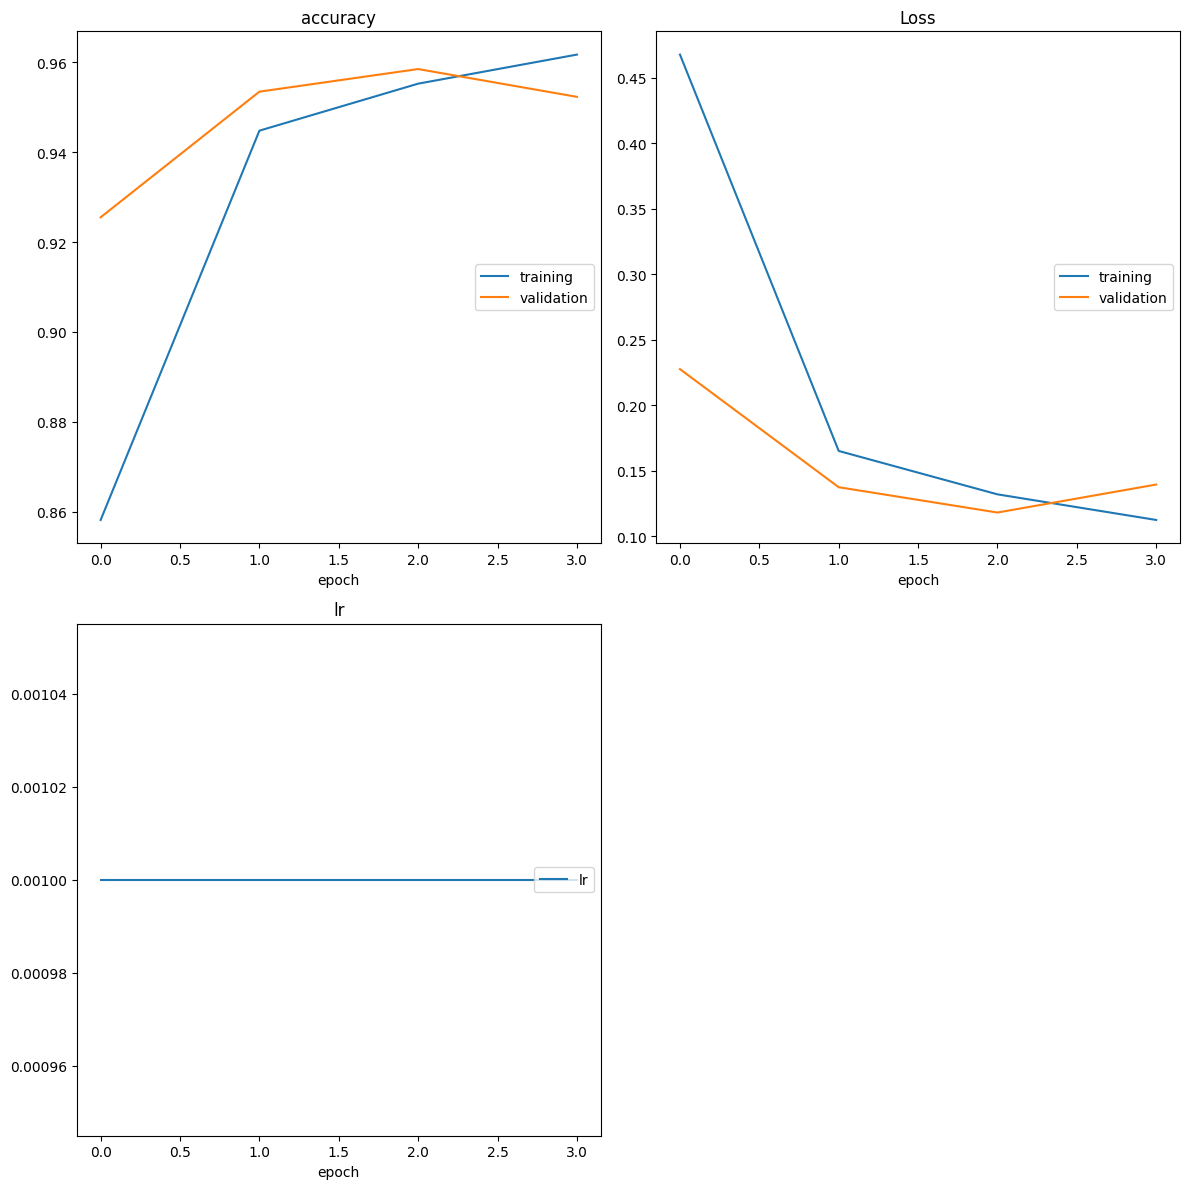

accuracy
	training         	 (min:    0.858, max:    0.962, cur:    0.962)
	validation       	 (min:    0.926, max:    0.958, cur:    0.952)
Loss
	training         	 (min:    0.112, max:    0.468, cur:    0.112)
	validation       	 (min:    0.118, max:    0.228, cur:    0.139)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
1740/1740 [==============================] - 3713s 2s/step - loss: 0.1124 - accuracy: 0.9617 - val_loss: 0.1394 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 5/10
 701/1740 [===========>..................] - ETA: 28:28 - loss: 0.1064 - accuracy: 0.9643

In [ ]:
inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

model.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
         tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
     ]
 )

In [ ]:
model.save('97 Sign Language ALS Classifier.h5')
results = model.evaluate(test_images)